In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, RocCurveDisplay)
from imblearn.metrics import specificity_score

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re




import matplotlib.pyplot as plt
%store -r dual_list


In [65]:
df_selftext = pd.read_csv('../../data/cleaned_selftext.csv')
df_notext = pd.read_csv('../../data/cleaned_notext.csv')
df_selftext.head(2)

,subreddit,text
0,0,using electric water boiler to mine bitcoin th...
1,0,btc to usdt hello i am looking to swap a good ...


In [66]:
print(df_selftext.subreddit.value_counts())
df_notext.subreddit.value_counts()

0    4017
1     787
Name: subreddit, dtype: int64


0    9938
1    2059
Name: subreddit, dtype: int64

# Adding all overlapping words to stoplist

In [67]:
stop = list(stopwords.words('english'))
stop.extend('btc eth bitcoin ethereum lightning vitalik metamask nft nfts'.split())
stop.extend([i for i in dual_list])


# Model

In [68]:
X = df_selftext.text
y = df_selftext.subreddit

In [69]:
y.value_counts(normalize=True)

0    0.836178
1    0.163822
Name: subreddit, dtype: float64

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [71]:
# Pipeline accepts multiple transformers, but only one vectorizer. See cgpt results:

'''The error message is caused by the fact that you are trying to fit two different vectorizers (TfidfVectorizer and CountVectorizer) 
in the same pipeline, but only providing one input (X_train) to the pipeline. This is causing the pipeline to raise an error as it doesn't 
know which vectorizer to apply to the input. 

You can fix this by either removing one of the vectorizers or providing separate inputs to the pipeline for each vectorizer.'''


nb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [72]:
nb_pipe_params = {
    'tvec__max_features': range(600,800,5),
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1,1), (1,2), (1,3),(2,3),(3,3)],
    'nb__alpha': [.01, .05, .1, .25, .5, .1]
}

In [73]:
rs = RandomizedSearchCV(nb_pipe, 
                  nb_pipe_params, 
                    cv = 5) 

In [74]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('nb', MultinomialNB())]),
                   param_distributions={'nb__alpha': [0.01, 0.05, 0.1, 0.25,
                                                      0.5, 0.1],
                                        'tvec__max_features': range(600, 800, 5),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3),
                                                              (3, 3)],
                                        'tvec__stop_words': [['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', 

In [75]:
#using all stopwords lowers scores to 0.8823747680890538 / 0.8654060066740823

print(rs.score(X_train, y_train))
rs.score(X_test, y_test)

0.9072994726616709


0.8959200666111574

In [76]:
#rs.best_params_

In [77]:
rs.score(X_test, y_test)

0.8959200666111574

In [78]:
preds = rs.predict(X_test)

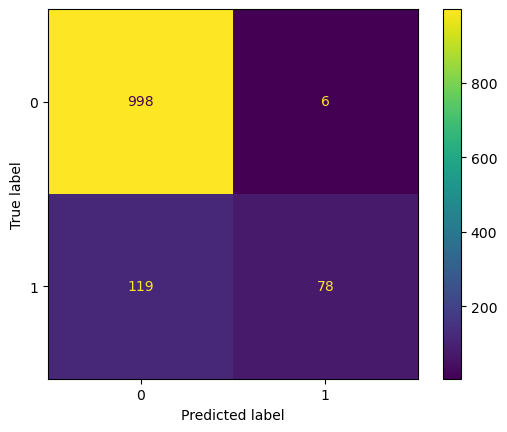

In [79]:
cm = confusion_matrix(y_test, preds)

display = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = rs.classes_)

display.plot();

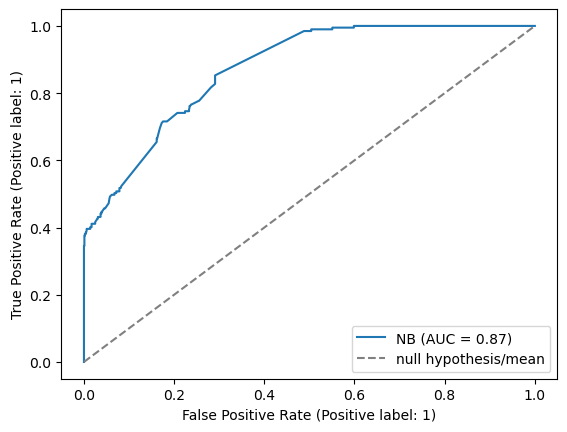

In [80]:
# Basic ROC

# cf ROC
# create an ax object
ax = plt.gca()

# use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(rs, X_test, y_test, ax=ax, name='NB')

# add 'worst case scenario' line
plt.plot([0,1], [0,1], label='null hypothesis/mean', linestyle='--', color='gray')

# necessary to label the baseline
plt.legend();

# Preds analysis

In [81]:
pred_df = pd.DataFrame(rs.predict_proba(X_test),columns=['bitcoin', 'ethereum'])

pred_df['true_values'] = y_test.values

pred_df.head()


,bitcoin,ethereum,true_values
0,0.836248,0.163752,0
1,0.782580,0.217420,1
2,0.999838,0.000162,0
3,0.994037,0.005963,0
4,0.970876,0.029124,0


In [82]:
full_pred_df = pd.DataFrame(rs.predict_proba(X),columns=['bitcoin', 'ethereum'])

In [83]:
full_pred_df['true_values'] = y.values

full_pred_df.head()

,bitcoin,ethereum,true_values
0,0.999872,0.000128,0
1,0.999854,0.000146,0
2,0.988418,0.011582,0
3,0.999642,0.000358,0
4,0.999945,0.000055,0


In [84]:
df_selftext

,subreddit,text
0,0,using electric water boiler to mine bitcoin th...
1,0,btc to usdt hello i am looking to swap a good ...
2,0,hypothetically what if we just treated bitcoin...
3,0,how to manage different btcs on one ledger so ...
4,0,can we discus dollar cost araging dca a an ins...
...,...,...
4799,1,how to generate your wallet friend we are glad...
4800,1,instagram is launching nft's on polygon this i...
4801,1,betplay fastest crypto casino with eth is one ...
4802,1,essay reducing the barrier for crypto using me...


In [85]:
df_selftext = df_selftext.join(full_pred_df)

In [86]:
df_selftext.sort_values(by = 'bitcoin')[0:100]

,subreddit,text,bitcoin,ethereum,true_values
4455,1,the daily gwei summary on the latest news on e...,4.029109e-08,1.000000,1
4534,1,layer solution zk rollups according to vitalik...,1.823179e-06,0.999998,1
4267,1,should we be concerned about the censorship is...,1.886500e-06,0.999998,1
4345,1,post merge ethereum fee continue to remain muc...,2.963420e-06,0.999997,1
4150,1,please help me to sir and madam i am asking fo...,3.765777e-06,0.999996,1
...,...,...,...,...,...
4045,1,need some assistance with an eth issue okay so...,4.653396e-04,0.999535,1
4310,1,what do you think a mature gamefi project need...,4.728902e-04,0.999527,1
4689,1,crypto gaming need to be fun to be successful ...,5.063218e-04,0.999494,1
4431,1,is there anyway to defeat someone using your o...,5.161778e-04,0.999484,1


# False negatives

In [87]:
df_selftext[(df_selftext.true_values == 1) & (df_selftext.bitcoin > .5)].sort_values(by = 'bitcoin', ascending = False)

,subreddit,text,bitcoin,ethereum,true_values
4553,1,what if a dao bought alexa from amazon i feel ...,0.994420,0.005580,1
4295,1,cbdcs good or bad for ethereum and crypto a a ...,0.987038,0.012962,1
4288,1,information information information i recently...,0.914382,0.085618,1
4549,1,gin robinhood is also for trading stock would ...,0.911963,0.088037,1
4083,1,did anyone's eth staking reward just randomly ...,0.874280,0.125720,1
...,...,...,...,...,...
4757,1,decentralised social network growing rapidly w...,0.609676,0.390324,1
4751,1,here are the top code contributor to the ether...,0.604116,0.395884,1
4639,1,another state quad state supply burnt or of st...,0.565470,0.434530,1
4208,1,interview about post quantum cryptography hey ...,0.550122,0.449878,1


In [88]:
# uncomment to see all ethereum posts that were categorized as BTC

#for i in df_selftext[(df_selftext.true_values == 1) & (df_selftext.bitcoin > .5)]['text']:
#    print(i, '\n')

# False Positives

In [89]:
bitcoinish_indexes = pred_df.loc[(pred_df['ethereum'] > .5) & (pred_df.true_values == 0)].index.values.astype(int)

In [90]:
for i in df_selftext.iloc[bitcoinish_indexes].text:
    print(i,'\n')

sell bitcoin now buy back at k either end of or early if you must do something with bitcoin short it one of my source pretty easy to track his accuracy by looking at his video during big btc market shift he's not been wrong yet 

crypto mining starter s support hey y'all i am trying to get into crypto mining and i 't know how for any of you that had successful i would lo if any of you could help me by just answering to some question to help me get started 

you won't want to miss out on this reason why bitcoin btc is the ultimate instment in share your thought in the comment hello bitcoin enthusiast a we enter the new year i wanted to share some thought on why i belie bitcoin btc is a strong instment opportunity in while many people are aware of the more well known reason for insting in btc such a it limited supply and role a a store of value here are some lesser known factor to consider institutional adoption in recent year we ha seen an increasing number of institutional instors such

In [91]:
#notes
def class_from_prob(probabilities, threshold):

    return [0 if prob < threshold else 1 for prob in probabilities]


In [92]:
threshold_list = [round(i*.01,2) for i in range(0,101,)]
speclist = []
senslist = []
f1list = []

for threshold in threshold_list:
    predicted_classes = class_from_prob(pred_df['ethereum'], threshold)
    spec = specificity_score(y_test, predicted_classes)
    sens = recall_score(y_test, predicted_classes, pos_label=1)
    speclist.append(spec)
    senslist.append(sens)
    F1 = f1_score(y_test, predicted_classes)
    f1list.append(F1)

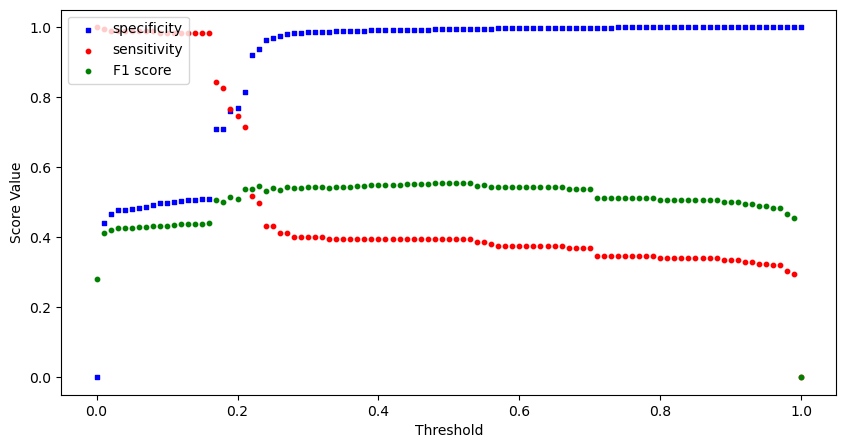

<Figure size 640x480 with 0 Axes>

In [93]:
%matplotlib inline
fig = plt.figure(figsize = (10,5));
ax1 = fig.add_subplot(111);

ax1.scatter(x = threshold_list, y = speclist, s=10, c='b', marker="s", label='specificity');
ax1.scatter(x = threshold_list,y = senslist, s=10, c='r', marker="o", label='sensitivity');
ax1.scatter(x = threshold_list,y = f1list, s=10, c='g', marker="o", label='F1 score');
plt.legend(loc='upper left')
plt.xlabel('Threshold');
plt.ylabel('Score Value');
plt.show();
plt.tight_layout();
